In [1]:
# Cell 1: Setup and Imports

import re
import os
import json
import torch
import warnings
import numpy as np
import pandas as pd
from umap import UMAP
import torch.nn as nn
from tqdm import tqdm
from tqdm.auto import tqdm 
from fuzzywuzzy import process
from haversine import haversine
import matplotlib.pyplot as plt
import torch.nn.functional as F
from scipy.stats import entropy
warnings.filterwarnings('ignore')
from itertools import permutations
from itertools import combinations
from sklearn.cluster import KMeans
from joblib import Parallel, delayed
from geopy.geocoders import Nominatim
from torch_geometric.nn import GCNConv
from sklearn.model_selection import KFold
from torch_geometric.data import HeteroData
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from geopy.extra.rate_limiter import RateLimiter
from sklearn.metrics.pairwise import haversine_distances
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from concurrent.futures import ThreadPoolExecutor, as_completed

# Configuration
DATA_PATH = "IncidentDataFinal.csv" 
SUBSTATION_PATH = "../Substation_Cleaned.csv"  
LINES_PATH = "../Lines_Cleaned.csv"           
MAX_WORKERS = 4

In [2]:
# Cell 2: Data Loader with Chunking
def clean_and_standardize_substations(substation_name):
    """Cleans substation names to a standardized '<feeder_id>:<substation_name>' format."""
    match = re.match(r"(\d+)\s*:\s*(.+)", substation_name.strip().upper())
    if match:
        feeder_id, name = match.groups()
        return f"{feeder_id}:{name.strip()}"
    else:
        return None  # Mark invalid format clearly


def load_data():
    # Read file once just to get columns
    cols = pd.read_csv(DATA_PATH, nrows=0).columns.tolist()
    
    # Choose only the date columns that exist
    date_cols = [c for c in ['Job OFF Time', 'Job ON Time'] if c in cols]

    incident_df = pd.read_csv(DATA_PATH, parse_dates=date_cols)

    # Clean and standardize Job Substation names explicitly
    incident_df['Job Substation'] = incident_df['Job Substation'].apply(clean_and_standardize_substations)
    dropped_count = incident_df['Job Substation'].isna().sum()
    incident_df.dropna(subset=['Job Substation'], inplace=True)

    # Load and clean substation data
    substation_df = pd.read_csv(SUBSTATION_PATH)
    substation_df['Name'] = substation_df['Name'].str.strip().str.upper()

    # Load lines data
    lines_df = pd.read_csv(LINES_PATH)

    print(f"Dropped {dropped_count} invalid substations due to format issues.")
    return incident_df, substation_df, lines_df


# Load all datasets
incident_df, substation_df, lines_df = load_data()
print(f"Loaded {len(incident_df)} incident records, {len(substation_df)} substations, {len(lines_df)} lines")

Dropped 0 invalid substations due to format issues.
Loaded 264458 incident records, 709 substations, 1040 lines


In [3]:
def calculate_centroids_and_feeders(incident_df, substation_df, threshold=70):
    """
    Processes incident and substation data to compute centroids, feeder info,
    and cities associated with each substation. Ensures Voltage is retained.
    """

    # Validate coordinate ranges using the correct columns
    assert (substation_df['X'].between(-180, 180).all()), "Invalid longitude in substation data"
    assert (substation_df['Y'].between(-90, 90).all()), "Invalid latitude in substation data"

    # Ensure X and Y are stored as full-precision float64
    substation_df['X'] = substation_df['X'].astype(float)
    substation_df['Y'] = substation_df['Y'].astype(float)

    # Clean and format names
    incident_df['Job Substation'] = incident_df['Job Substation'].str.strip().str.upper()
    substation_df['Name'] = substation_df['Name'].str.strip().str.upper()

    # Swap "<feeder>:<name>" -> "<name> <feeder>" if present
    incident_df['Formatted Job Substation'] = incident_df['Job Substation'].apply(
        lambda x: f"{x.split(':')[1].strip()} {x.split(':')[0].strip()}"
        if isinstance(x, str) and ":" in x and len(x.split(':')) == 2 else x
    )

    # Fuzzy matching
    substation_names = substation_df['Name'].tolist()
    fuzzy_matches = {}
    for incident_name in incident_df['Formatted Job Substation'].dropna().unique():
        best_match, score = process.extractOne(incident_name, substation_names)
        fuzzy_matches[incident_name] = best_match if score >= threshold else None

    incident_df['Matched Substation'] = incident_df['Formatted Job Substation'].map(fuzzy_matches)
    incident_df['Unmatched_Flag'] = incident_df['Matched Substation'].isna()

    # Keep only substation rows that were matched
    matched_subs = set(incident_df['Matched Substation'].dropna().unique())
    valid_substations = substation_df[substation_df['Name'].isin(matched_subs)]

    # -------- feeders (use 'Feeder ID' if present, else 'Substation ID') --------
    feeder_col = 'Feeder ID' if 'Feeder ID' in incident_df.columns else 'Substation ID'
    feeder_agg = (
        incident_df[~incident_df['Unmatched_Flag']]
        .groupby('Matched Substation')[feeder_col]
        .agg(lambda x: sorted(set(map(str, x))) if not x.empty else [])
        .reset_index()
        .rename(columns={feeder_col: 'feeders'})
    )

    # -------- cities (optional; only if Job City_imputed exists) --------
    if 'Job City_imputed' in incident_df.columns:
        city_agg = (
            incident_df[~incident_df['Unmatched_Flag']]
            .groupby('Matched Substation')['Job City_imputed']
            .agg(lambda x: sorted(set(map(str, x))) if not x.empty else [])
            .reset_index(name='cities')
        )
    else:
        city_agg = pd.DataFrame({'Matched Substation': list(matched_subs), 'cities': [[]]*len(matched_subs)})

    # Merge substation coordinates with feeder and city information
    centroids = valid_substations.rename(columns={'Name': 'Matched Substation'})
    keep_cols = ['Matched Substation', 'X', 'Y'] + (['Voltage'] if 'Voltage' in valid_substations.columns else [])
    centroids = centroids[keep_cols]
    centroids = centroids.merge(feeder_agg, on='Matched Substation', how='left')
    centroids = centroids.merge(city_agg, on='Matched Substation', how='left')

    # Restore original Job Substation for readability
    incident_mapping = incident_df[['Matched Substation', 'Job Substation']].drop_duplicates()
    centroids = centroids.merge(incident_mapping, on='Matched Substation', how='left')
    centroids['Job Substation'] = centroids['Job Substation'].fillna(centroids['Matched Substation'])
    centroids.drop(columns=['Matched Substation'], inplace=True)

    # Full precision and rename for clarity
    centroids['X'] = centroids['X'].map(lambda x: float(f"{x:.12f}"))
    centroids['Y'] = centroids['Y'].map(lambda x: float(f"{x:.12f}"))
    centroids = centroids.rename(columns={'X': 'centroid_lon', 'Y': 'centroid_lat'})

    # -------- metadata integration (optional) --------
    metadata_cols = [c for c in ['Name', 'PLANTCLASS'] if c in substation_df.columns]
    if metadata_cols:
        centroids = centroids.merge(
            substation_df[metadata_cols].rename(columns={'Name': 'Job Substation'}),
            on='Job Substation',
            how='left'
        )
        if 'PLANTCLASS' in centroids.columns:
            centroids['PLANTCLASS'] = centroids['PLANTCLASS'].fillna('Unknown')

    # Unmatched for review
    unmatched_substations = incident_df[incident_df['Unmatched_Flag']][['Job Substation']].drop_duplicates()
    print(f"Info: {len(unmatched_substations)} substations did not match and are flagged for review.")

    # Debug precision print
    print(centroids[['centroid_lon', 'centroid_lat']].applymap(lambda x: f"{x:.12f}"))

    return centroids, unmatched_substations


# Usage example:
centroids, unmatched = calculate_centroids_and_feeders(incident_df, substation_df)
print(f"Final centroids: {len(centroids)} substations (only those with incidents and coordinates)")
print(f"Unmatched substations: {len(unmatched)} (flagged for further review)")


Info: 0 substations did not match and are flagged for review.
         centroid_lon     centroid_lat
0    -96.739096680000  34.956678930000
1    -96.931588840000  35.065887700000
2    -96.636865090000  35.144505620000
3    -96.808118810000  35.131121870000
4    -96.497140190000  35.145120520000
..                ...              ...
189  -96.861282820000  35.707718530000
190  -94.359171320000  35.453499690000
191  -97.451500000000  35.769200000000
192  -97.489830750000  35.470226020000
193  -96.652016390000  34.752418670000

[194 rows x 2 columns]
Final centroids: 194 substations (only those with incidents and coordinates)
Unmatched substations: 0 (flagged for further review)


In [5]:
# Cell 4 : Proximity Threshold Calculation + Line Matching

def calculate_proximity_threshold(incident_df, centroids):
    """Calculate median distance between substations co-affected by weather events with validation.
    """

    # Step 1: Dynamically extract all weather-related causes
    weather_terms = [
        'WEATHER', 'STORM', 'LIGHTNING', 'WILDFIRE', 'RAIN', 'WIND', 'SNOW', 
        'FOG', 'EXTREME COLD', 'EXTREME HEAT', 'ICE', 'SLEET', 'HIGH WINDS'
    ]
    
    # Extract all unique cause descriptions that contain any weather-related term
    weather_causes_list = [
        cause for cause in incident_df['Cause Desc'].dropna().unique() 
        if any(term in cause.upper() for term in weather_terms)
    ]
    
    print(f"Identified {len(weather_causes_list)} weather-related causes:\n{weather_causes_list}\n")

    # Step 2: Filter weather-related incidents
    weather_mask = incident_df['Cause Desc'].isin(weather_causes_list)
    weather_subs = incident_df[weather_mask]['Job Substation'].unique()

    # Step 3: Check for missing substations in centroids
    sub_coords = centroids.set_index('Job Substation')[['centroid_lat', 'centroid_lon']].to_dict('index')
    missing_subs = [sub for sub in weather_subs if sub not in sub_coords]

    if missing_subs:
        print(f"⚠️ Warning: {len(missing_subs)} substations affected by weather incidents do not have coordinates in centroids.")
        print(f"Missing substations: {missing_subs}\n")

    # Step 4: Calculate pairwise distances (only for existing substations)
    distances = []

    for (sub1, sub2) in combinations(weather_subs, 2):
        if sub1 in sub_coords and sub2 in sub_coords:
            coord1 = np.radians([sub_coords[sub1]['centroid_lat'], sub_coords[sub1]['centroid_lon']])
            coord2 = np.radians([sub_coords[sub2]['centroid_lat'], sub_coords[sub2]['centroid_lon']])

            distance = haversine_distances([coord1, coord2])[0, 1] * 6371  # Convert to km
            distances.append(distance)

    # Step 5: Validate and compute proximity threshold
    if len(distances) < 10:
        print("⚠️ Warning: Insufficient weather pairs - consider manual threshold.")

    # Step 6: Return the 75th percentile of distances, or default to 20km if no data
    proximity_threshold = np.percentile(distances, 75) if distances else 20
    print(f"Calculated proximity threshold: {proximity_threshold:.2f} km")

    return proximity_threshold


def get_line_substations(line_row, valid_subs, fuzzy_threshold=64, manual_check_threshold=55):
    """
    Matches a transmission line to substations using fuzzy name matching.
    Extracts the voltage from the 'Const_Volt' column.
    Automatically adds matches with a score >= fuzzy_threshold.
    Flags matches with a score between manual_check_threshold and fuzzy_threshold for manual review.
    Ignores matches with a score below manual_check_threshold.
    """
    # Use the 'LINENAME' column for the line description
    line_str = line_row.get('LINENAME', '')  
    voltage = line_row.get('Const_Volt', None)

    # Ensure line_str is a string before applying regex
    if not isinstance(line_str, str) or line_str.strip() == "":
        return []  # Return an empty list if line name is missing

    # Remove any parentheses content to clean the line string
    clean_line = re.sub(r'\(.*?\)', '', line_str).strip()

    subs = []
    low_confidence_matches = []  # Store potential matches that need manual review

    # Split the clean line by '-' to get potential substation parts
    for part in clean_line.split('-'):
        part_clean = part.strip()
        if part_clean:
            match, score = process.extractOne(part_clean, valid_subs)
            if score >= fuzzy_threshold:
                subs.append((match, voltage))
            elif score >= manual_check_threshold:
                # Flag for manual review but don't add
                low_confidence_matches.append((part_clean, match, score))
            else:
                # Score is below the manual check threshold, so ignore this match entirely
                pass

    # Print low-confidence matches for manual review
    if low_confidence_matches:
        print(f"⚠️ Manual Review Needed: Low-confidence matches detected for '{line_row.get('LINENAME', 'UNKNOWN')}':")
        for original, suggested, score in low_confidence_matches:
            print(f"  - '{original}' matched with '{suggested}' (Score: {score}) ❌ Not Added")

    return list(set(subs))




In [6]:
# Cell 5 : Spatial Layer Construction
def build_spatial_layer(lines_df, centroids, incident_df, fuzzy_threshold=80):
    """Builds a spatial graph layer using both physical transmission lines and geographic proximity."""
    
    # Step 1: Calculate proximity threshold
    proximity_threshold_km = calculate_proximity_threshold(incident_df, centroids)
    
    # Step 2: Prepare substation data
    sub_coords = centroids.set_index('Job Substation')
    valid_subs = sub_coords.index.tolist()
    coords_dict = sub_coords[['centroid_lon', 'centroid_lat']].to_dict('index')
    voltage_dict = sub_coords['Voltage'].to_dict()
    
    # Feature dictionaries
    city_dict = centroids.set_index('Job Substation')['cities'].apply(
        lambda x: set(x) if isinstance(x, list) else set()).to_dict()
    feeder_dict = centroids.set_index('Job Substation')['feeders'].apply(
        lambda x: set(x) if isinstance(x, list) else set()).to_dict()

    # Step 3: Phase 1 - Physical Line Connections
    line_edges = []
    for _, line in lines_df.iterrows():
        subs_voltages = get_line_substations(line, valid_subs, fuzzy_threshold)

        for (src, src_volt), (dst, dst_volt) in permutations(subs_voltages, 2):
            line_edges.append({
                'source': src, 'target': dst,
                'has_line': 1,
                'line_voltage': src_volt or dst_volt,
                'line_length_km': line['SHAPE_LEN'] / 1000 if line['SHAPE_LEN'] > 0 else 0.0,
                'is_nearby': 0
            })

    # Step 4: Phase 2 - Proximity Edges with Voltage Filtering
    proximity_edges = []
    for (src, dst) in combinations(valid_subs, 2):
        if voltage_dict[src] == voltage_dict[dst]:  # Voltage-based filtering
            src_coord = np.radians([coords_dict[src]['centroid_lon'], coords_dict[src]['centroid_lat']])
            dst_coord = np.radians([coords_dict[dst]['centroid_lon'], coords_dict[dst]['centroid_lat']])
            distance_km = haversine_distances([src_coord, dst_coord])[0, 1] * 6371  # Convert to km

            if distance_km <= proximity_threshold_km:
                proximity_edges.append({
                    'source': src, 'target': dst,
                    'has_line': 0,
                    'line_voltage': None,
                    'line_length_km': 0.0,
                    'is_nearby': 1
                })

    # Step 5: Combine and Enhance Features
    all_edges = pd.DataFrame(line_edges + proximity_edges)
    all_edges = all_edges.groupby(['source', 'target'], as_index=False).agg({
        'has_line': 'max',
        'is_nearby': 'max',
        'line_voltage': 'first',
        'line_length_km': 'first'
    })

    # Step 6: Add Shared Features
    shared_data = []
    for s, d in zip(all_edges['source'], all_edges['target']):
        shared_cities = len(city_dict.get(s, set()) & city_dict.get(d, set()))
        shared_feeders = len(feeder_dict.get(s, set()) & feeder_dict.get(d, set()))
        shared_data.append({'source': s, 'target': d, 'shared_cities': shared_cities, 'shared_feeders': shared_feeders})

    all_edges = all_edges.merge(pd.DataFrame(shared_data), on=['source', 'target'])

    
    # Step 7: Add Distance Feature and Edge Weights
    all_edges['distance_km'] = all_edges.apply(
        lambda row: haversine_distances(
            [np.radians([coords_dict[row['source']]['centroid_lon'], coords_dict[row['source']]['centroid_lat']]),
             np.radians([coords_dict[row['target']]['centroid_lon'], coords_dict[row['target']]['centroid_lat']])]
        )[0, 1] * 6371, axis=1
    )

    # Add distance-decay weight
    all_edges['weight'] = np.where(all_edges['has_line'] == 1, 1.0, 1 / (1 + all_edges['distance_km']))

    print(f" Spatial layer built with {len(all_edges)} edges.")

    return all_edges

# Usage
#spatial_edges = build_spatial_layer(lines_df, centroids, incident_df)
spatial_edges = build_spatial_layer(lines_df, centroids, incident_df, fuzzy_threshold=64)

print(f"Proximity threshold: {spatial_edges['distance_km'].median():.1f} km (auto-calculated)")

Identified 12 weather-related causes:
['LIGHTNING', 'WIND', 'ICE / SLEET / SNOW', 'Weather \\ Lightning', 'Weather \\ High Winds', 'Weather \\ Extreme Cold', 'Weather \\ Extreme Heat', 'Weather \\ Rain', 'Weather \\ Ice', 'WILDFIRE', 'Weather \\ Snow', 'Weather \\ Fog']

Calculated proximity threshold: 222.85 km
⚠️ Manual Review Needed: Low-confidence matches detected for 'ROSEHILL - KANSAS BORDER':
  - 'ROSEHILL' matched with '4707:KNOBHILL' (Score: 60) ❌ Not Added
⚠️ Manual Review Needed: Low-confidence matches detected for 'RANCH ROAD - SOONER':
  - 'SOONER' matched with '8474:STONEWALL' (Score: 60) ❌ Not Added
⚠️ Manual Review Needed: Low-confidence matches detected for 'SUNNYSIDE - HUGO EAST':
  - 'SUNNYSIDE' matched with '8617:SUNNYLANE' (Score: 60) ❌ Not Added
⚠️ Manual Review Needed: Low-confidence matches detected for 'SUNNYSIDE - HUGO WEST':
  - 'SUNNYSIDE' matched with '8617:SUNNYLANE' (Score: 60) ❌ Not Added
  - 'HUGO WEST' matched with '7118:KEY WEST' (Score: 59) ❌ Not Add

In [8]:
# Cell 6 : Temporal Layer with Adaptive Window (Improved)

# Declare global time_window
time_window = None

def calculate_temporal_window(df, percentile):
    """Calculate window using time BETWEEN incidents"""
    sorted_df = df.sort_values('Job OFF Time')
    times = pd.to_datetime(sorted_df['Job OFF Time']).values.astype('datetime64[m]')
    
    inter_arrivals = np.diff(times).astype('timedelta64[m]').astype(int)
    return np.percentile(inter_arrivals, percentile)

def build_temporal_layer(df, percentile, min_cooccur="auto", n_jobs=8):
    """Temporal edges with adaptive co-occurrence threshold"""

    global time_window  # Declare time_window as global
    
    # Clean and sort
    df = df.dropna(subset=['Job OFF Time']).copy()
    df['Job OFF Time'] = pd.to_datetime(df['Job OFF Time'])
    df = df.sort_values('Job OFF Time').reset_index(drop=True)
    
    # Calculate adaptive window ()
    time_window = calculate_temporal_window(df, percentile)
    print(f"Network-wide window: {time_window} mins ({percentile}th percentile)")

    # Vectorized processing
    subs = df['Job Substation'].values
    times = df['Job OFF Time'].values.astype(np.int64)
    
    def process_chunk(start_idx):
        chunk_edges = []
        for i in range(start_idx, min(start_idx+1000, len(df))):
            max_time = times[i] + int(time_window * 6e10)  # mins to ns
            j_end = np.searchsorted(times, max_time, side='right')
            
            for j in range(i+1, j_end):
                if subs[i] != subs[j]:
                    delta = (times[j] - times[i]) / 6e10  # mins
                    decay = np.exp(-delta / 60)  # 1hr halflife
                    chunk_edges.append((subs[i], subs[j], decay))
        return chunk_edges
    
    # Parallel execution
    chunk_indices = range(0, len(df), 1000)
    results = Parallel(n_jobs=n_jobs)(
        delayed(process_chunk)(i) for i in tqdm(chunk_indices, desc="Processing temporal chunks")
    )
    
    # Aggregate edges
    edges = pd.DataFrame(
        [item for chunk in results for item in chunk],
        columns=['source', 'target', 'weight']
    )
    
    # Calculate dynamic threshold
    aggregated = edges.groupby(['source', 'target']).agg(
        total_weight=('weight', 'sum'),
        count=('weight', 'size')
    ).reset_index()
    
    if min_cooccur == "auto":
        # More conservative threshold calculation
        threshold = max(3, int(np.percentile(aggregated['count'], 50)))  # Median calculation
        print(f"Auto min_cooccur: {threshold} (median)")
        temporal_edges = aggregated[aggregated['count'] >= threshold]
    else:
        temporal_edges = aggregated[aggregated['count'] >= min_cooccur]
    
    return temporal_edges

# Usage
temporal_edges = build_temporal_layer(incident_df, min_cooccur="auto" , percentile=80)
print(f"Temporal edges within adaptive window: {len(temporal_edges)}")

Network-wide window: 15.0 mins (80th percentile)


Processing temporal chunks:   0%|          | 0/265 [00:00<?, ?it/s]

Auto min_cooccur: 21 (median)
Temporal edges within adaptive window: 19134


In [9]:
# Cell 7: Causal Layer 

def build_causal_layer(df, spatial_edges, fixed_window=24, percentile=80, 
                      n_jobs=4, min_cooccur=2, progress=True):
    """
    Final causal layer implementation with validated causes
    """
    # 1. Curated list of meaningful failure causes
    valid_causes = [
    # Weather-related (expanded)
    'LIGHTNING', 'ICE / SLEET / SNOW', 'WIND', 'WILDFIRE',
    'Weather \\ Lightning', 'Weather \\ High Winds', 'Weather \\ Ice',
    'Weather \\ Extreme Heat', 'Weather \\ Extreme Cold', 
    'Weather \\ Rain', 'Weather \\ Snow', 'Weather \\ Fog',

    # Vegetation-related (already included)
    'TREES : GROW IN', 'TREE:NON PREVENTABLE',

    # Animal-related (expanded slightly)
    'SQUIRREL', 'WILDLIFE OTHER THAN SQUIRREL (DESCRIBE)',

    # Equipment failures (expanded significantly)
    'DETERIORATION', 'BREAKER', 'ELECTRICAL TRACKING', 'POOR CONNECTION',
    'OVERLOAD', 'PREMATURE FAILURE', 'DAMAGED BY PUBLIC',
    'Elec \\ Broken', 'Elec \\ Loose Connection', 'Elec \\ Open',
    'Elec \\ Animal Contact', 'Elec \\ Cracked', 'Elec \\ Insulation',
    'Elec \\ Contact', 'Elec \\ Corrosion',

    # Mechanical failures (newly added, low counts but relevant)
    'Mech \\ Leaking', 'Mech \\ Broken', 'Mech \\ Wear',
    'Mech \\ Binding', 'Mech \\ Dirty / Sticky',

    # Transmission-related (newly added, low counts but relevant)
    'Transm Line \\ Other [Describe]', 'Transm Line \\ On Right-of-Way',
    'Transm Line \\ Under Line', 'Transm Str \\ Electrical Tracking',
    'Transm Str \\ Decay', 'Transm Str \\ Lightning', 'Transm Str \\ Other [Describe]',
    'Transm Sw \\ Other [Describe]'
]


    # 2. Filter dataset to only valid causes
    causal_df = df[df['Cause Desc'].isin(valid_causes)].copy()
    causal_df['Job OFF Time'] = pd.to_datetime(causal_df['Job OFF Time'], errors='coerce')
    causal_df = causal_df.dropna(subset=['Job OFF Time'])

    # 3. Calculate temporal parameters
    min_time = causal_df['Job OFF Time'].min()
    max_time = causal_df['Job OFF Time'].max()
    total_hours = (max_time - min_time).total_seconds() / 3600

    # 4. Dynamic window calculation per cause
    failure_groups = (
        causal_df.groupby(['Job Substation', 'Cause Desc'])['Job OFF Time']
        .apply(np.sort)
        .reset_index(name='failure_times')
    )
    
    def get_cause_window(cause_group):
        all_times = np.concatenate(cause_group['failure_times'].values)
        if len(all_times) < 2:
            return fixed_window
        diffs = np.diff(np.sort(all_times)).astype('timedelta64[h]').astype(float)
        valid_diffs = diffs[diffs > 0]
        if len(valid_diffs) == 0:
            return fixed_window
        return min(np.percentile(valid_diffs, 75), fixed_window)
    
    cause_windows = (
        failure_groups.groupby('Cause Desc')
        .apply(get_cause_window)
        .to_dict()
    )

    # 5. Spatial relationships filtering
    spatial_pairs = set(frozenset({row['source'], row['target']}) 
                      for _, row in spatial_edges.iterrows())

    # 6. Core processing with enhanced statistics
    def process_cause(cause):
        window = cause_windows.get(cause, fixed_window)
        subs_data = failure_groups[failure_groups['Cause Desc'] == cause]
        edges = []
        
        sub_times = {
            row['Job Substation']: row['failure_times'].astype(np.int64) // 1e9
            for _, row in subs_data.iterrows()
        }
        
        for a, b in combinations(sub_times.keys(), 2):
            if frozenset({a, b}) not in spatial_pairs:
                continue
                
            a_ts = sub_times[a][:, None]
            b_ts = sub_times[b][None, :]
            diffs = np.abs(a_ts - b_ts) / 3600  # Hours
            
            valid_mask = diffs <= window
            count = valid_mask.sum()
            if count < min_cooccur:
                continue
                
            # Enhanced statistical model
            n_a, n_b = len(a_ts), len(b_ts)
            window_days = window / 24
            daily_prob = (n_a / total_hours*24) * (n_b / total_hours*24)
            expected = daily_prob * window_days * (total_hours/24)
            
            if expected < 1e-6:
                continue
                
            z = (count - expected) / np.sqrt(expected)
            
            edges.append({
                'source': a,
                'target': b,
                'cause': cause,
                'z_score': z,
                'cooccur_count': count,
                'expected_random': round(expected, 2),
                'window_hrs': window
            })
            
        return edges

    # 7. Parallel execution with progress
    all_causes = failure_groups['Cause Desc'].unique()
    
    if progress:
        print(f"Processing {len(all_causes)} causal factors...")
        from tqdm import tqdm
        with tqdm(total=len(all_causes)) as pbar:
            results = Parallel(n_jobs=n_jobs)(
                delayed(process_cause)(cause)
                for cause in all_causes
            )
            pbar.update(len(all_causes))
    else:
        results = Parallel(n_jobs=n_jobs)(
            delayed(process_cause)(cause) for cause in all_causes
        )

    # 8. Post-processing and filtering
    causal_edges = pd.DataFrame([edge for sublist in results for edge in sublist])
    
    if not causal_edges.empty:
        # Apply adaptive threshold (top 1% significant edges)
        z_threshold = causal_edges['z_score'].quantile(0.85)
        causal_edges = causal_edges[
            (causal_edges['z_score'] >= z_threshold) &
            (causal_edges['cooccur_count'] >= min_cooccur)
        ]
        
        # Calculate normalized metrics
        causal_edges['cooccur_ratio'] = causal_edges['cooccur_count'] / \
                                      (causal_edges['cooccur_count'] + 
                                       causal_edges['expected_random'])
        
        # Final feature selection
        keep_cols = ['source', 'target', 'cause', 'z_score', 
                    'cooccur_ratio', 'window_hrs', 'cooccur_count']
        causal_edges = causal_edges[keep_cols]

    return causal_edges.reset_index(drop=True), cause_windows

# Generate causal edges
causal_edges, windows = build_causal_layer(
    df=incident_df,
    spatial_edges=spatial_edges,
    fixed_window=72,  # Max window cap
    min_cooccur=3,    # Min 3 co-occurrences
    n_jobs=8
)

# Analyze results
print(f"Final causal network: {len(causal_edges)} edges")
print("Top connections:")
print(causal_edges.sort_values('z_score', ascending=False).head(10))

Processing 42 causal factors...


100%|██████████| 42/42 [00:01<00:00, 27.92it/s]


Final causal network: 7192 edges
Top connections:
                   source       target               cause       z_score  \
6749          8416:DUNJEE  8522:MIDWAY  ICE / SLEET / SNOW  64460.743694   
6889      8519:NE 10TH ST  8522:MIDWAY  ICE / SLEET / SNOW  61833.046667   
6111  8312:BELLE ISLE STA  8522:MIDWAY  ICE / SLEET / SNOW  59521.192409   
5600    8170:SANTA FE AVE  8522:MIDWAY  ICE / SLEET / SNOW  58958.798889   
5059       7430:INGLEWOOD  8522:MIDWAY  ICE / SLEET / SNOW  56616.941877   
5707         8209:CLASSEN  8522:MIDWAY  ICE / SLEET / SNOW  56604.691952   
6630        8365:LAKESIDE  8522:MIDWAY  ICE / SLEET / SNOW  54138.217338   
6368       8336:TENNESSEE  8522:MIDWAY  ICE / SLEET / SNOW  53212.152136   
5486            8158:SARA  8522:MIDWAY  ICE / SLEET / SNOW  52884.037706   
6407   8337:EIGHTY FOURTH  8522:MIDWAY  ICE / SLEET / SNOW  52846.278945   

      cooccur_ratio  window_hrs  cooccur_count  
6749       0.999997        15.0          12343  
6889       0.99

In [10]:
import numpy as np
import pandas as pd

def create_clean_node_features(incident_df):
    """
    Minimal, CSV-aligned node features:
      node_features = [
        'X','Y','Voltage','Distribution, Substation, Transmission',
        'Job Substation','Substation ID','PLANTSTATU','no_feeders','no_cities'
      ]
      network_features = ['total_line_length','avg_line_voltage','num_connections']
      prior_incident_features = ['prior_avg_cust_affected','prior_avg_downtime',
                                 'prior_incident_count','prior_avg_no_calls']
      incident_features = ['Call Qty','Job Duration Mins','Custs Affected','Year',
                           'Major Storm Event  Y (Yes) or N (No)']
    Aggregates sensibly and returns one row per Job Substation.
    """

    df = incident_df.copy()
    df['Job Substation'] = df['Job Substation'].astype(str).str.strip().str.upper()

    # Helper: mode for categoricals
    def mode_or_nan(s):
        s = s.dropna()
        return s.mode().iloc[0] if not s.empty else np.nan

    # Storm col → map to {Y/YES:1, N/NO:0} then mean -> share of storm incidents
    storm_col = 'Major Storm Event  Y (Yes) or N (No)'
    if storm_col in df.columns:
        df[storm_col] = (
            df[storm_col].astype(str).str.upper().str.strip()
              .map({'Y':1, 'YES':1, 'N':0, 'NO':0})
        )

    # Build aggregation map only for columns that exist
    agg_plan = {
        # Node features
        'X': 'mean',
        'Y': 'mean',
        'Voltage': 'mean',
        'Distribution, Substation, Transmission': mode_or_nan,
        'Substation ID': mode_or_nan,
        'PLANTSTATU': mode_or_nan,
        'no_feeders': 'mean',
        'no_cities': 'mean',

        # Network features
        'total_line_length': 'mean',
        'avg_line_voltage': 'mean',
        'num_connections': 'max',  # take the max observed

        # Prior incident features
        'prior_avg_cust_affected': 'mean',
        'prior_avg_downtime': 'mean',
        'prior_incident_count': 'mean',
        'prior_avg_no_calls': 'mean',

        # Incident features
        'Call Qty': 'sum',              # total calls across incidents
        'Job Duration Mins': 'mean',    # typical duration
        'Custs Affected': 'sum',        # total affected across incidents
        'Year': mode_or_nan,            # most common year
        storm_col: 'mean'               # share of storm incidents
    }

    # Keep only columns that are present to avoid KeyErrors
    present_aggs = {k:v for k,v in agg_plan.items() if k in df.columns}

    node = df.groupby('Job Substation').agg(present_aggs).reset_index()

    # Reorder to your preferred column order (include only those that exist)
    node_features = [
        'X','Y','Voltage','Distribution, Substation, Transmission',
        'Job Substation','Substation ID','PLANTSTATU','no_feeders','no_cities'
    ]
    network_features = ['total_line_length','avg_line_voltage','num_connections']
    prior_incident_features = ['prior_avg_cust_affected','prior_avg_downtime',
                               'prior_incident_count','prior_avg_no_calls']
    incident_features = ['Call Qty','Job Duration Mins','Custs Affected','Year', storm_col]

    desired_order = (['Job Substation'] + node_features + network_features +
                     prior_incident_features + incident_features)

    node = node[[c for c in desired_order if c in node.columns]]

    return node


# Example usage
node_features_clean = create_clean_node_features(incident_df)
print(node_features_clean.head())



       Job Substation          X          Y  Voltage  \
0  3109:HONOR HEIGHTS -95.412010  35.771211     69.0   
1      3110:RIVERSIDE -95.322400  35.762029     69.0   
2    3111:FIVE TRIBES -95.396671  35.725030    161.0   
3       3114:TENNYSON -95.396408  35.746585     69.0   
4        3128:HANCOCK -95.347455  35.724962    161.0   

  Distribution, Substation, Transmission      Job Substation  Substation ID  \
0                           DISTRIBUTION  3109:HONOR HEIGHTS           3109   
1                           DISTRIBUTION      3110:RIVERSIDE           3110   
2                           DISTRIBUTION    3111:FIVE TRIBES           3111   
3                           DISTRIBUTION       3114:TENNYSON           3114   
4                           DISTRIBUTION        3128:HANCOCK           3128   

  PLANTSTATU  no_feeders  no_cities  ...  num_connections  \
0          A         2.0        6.0  ...              2.0   
1          A         5.0        1.0  ...              4.0   
2    

In [11]:
# --- Normalize node + edge identifiers to the same canonical form (UPPER + strip) ---

# Drop duplicate 'Job Substation' column (you have it twice)
node_features_clean = node_features_clean.loc[:, ~node_features_clean.columns.duplicated()].copy()

# Normalize node names
node_features_clean['Job Substation'] = (
    node_features_clean['Job Substation'].astype(str).str.strip().str.upper()
)

# Normalize edge names
for _edges in [spatial_edges, temporal_edges, causal_edges]:
    for col in ['source', 'target']:
        _edges[col] = _edges[col].astype(str).str.strip().str.upper()

# Debug: do endpoints exist as node names?
name_set = set(node_features_clean['Job Substation'].tolist())
for nm, df in [('spatial', spatial_edges), ('temporal', temporal_edges), ('causal', causal_edges)]:
    both_in = (df['source'].isin(name_set) & df['target'].isin(name_set)).sum()
    print(f"{nm}: total={len(df)} | both_endpoints_in_nodes={both_in}")
    if both_in == 0:
        print(f"  -> WARNING: {nm} edges still don’t match; check spelling/casing/whitespace.")


spatial: total=7738 | both_endpoints_in_nodes=7738
temporal: total=19134 | both_endpoints_in_nodes=19134
causal: total=7192 | both_endpoints_in_nodes=7192


In [12]:
import numpy as np
import torch
from torch_geometric.data import HeteroData

# --- Build node matrix (numeric only), but keep names for node_ids ---
X_num = (
    node_features_clean.select_dtypes(include=[np.number])
    .replace([np.inf, -np.inf], np.nan)
    .fillna(0.0)
)
node_names = node_features_clean['Job Substation'].tolist()
name_to_idx = {n: i for i, n in enumerate(node_names)}

data = HeteroData()
data['substation'].x = torch.tensor(X_num.to_numpy(), dtype=torch.float32)
data['substation'].node_ids = node_names  # <-- store real names so edges can match

# Optional: keep Substation ID aligned (handy later)
if 'Substation ID' in node_features_clean.columns:
    sid_aligned = node_features_clean['Substation ID'].tolist()
    data['substation'].substation_id = sid_aligned

def _add_edges(df, etype):
    # keep only edges whose endpoints exist
    mask = df['source'].isin(name_to_idx) & df['target'].isin(name_to_idx)
    kept = df.loc[mask].copy()
    src = kept['source'].map(name_to_idx).to_numpy()
    dst = kept['target'].map(name_to_idx).to_numpy()
    edge_index = torch.tensor(np.vstack([src, dst]), dtype=torch.long)
    data['substation', etype, 'substation'].edge_index = edge_index

    # numeric edge attributes only
    ea = (
        kept.drop(columns=['source','target'], errors='ignore')
            .select_dtypes(include=[np.number])
            .replace([np.inf, -np.inf], np.nan)
            .fillna(0.0)
    )
    if ea.shape[1] > 0:
        data['substation', etype, 'substation'].edge_attr = torch.tensor(ea.to_numpy(), dtype=torch.float32)
    print(f"{etype}: provided={len(df)} | kept={edge_index.size(1)}")

# Add all three edge types
_add_edges(spatial_edges,  'spatial')
_add_edges(temporal_edges, 'temporal')
_add_edges(causal_edges,   'causal')

# Save and print summary
torch.save(data, "Hetero_Final_NW_graph_fixed_kara.pt")
print("\nSaved -> Hetero_Final_NW_graph_fixed_kara.pt")
print(data)


spatial: provided=7738 | kept=7738
temporal: provided=19134 | kept=19134
causal: provided=7192 | kept=7192

Saved -> Hetero_Final_NW_graph_fixed_kara.pt
HeteroData(
  substation={
    x=[194, 18],
    node_ids=[194],
    substation_id=[194],
  },
  (substation, spatial, substation)={
    edge_index=[2, 7738],
    edge_attr=[7738, 8],
  },
  (substation, temporal, substation)={
    edge_index=[2, 19134],
    edge_attr=[19134, 2],
  },
  (substation, causal, substation)={
    edge_index=[2, 7192],
    edge_attr=[7192, 4],
  }
)


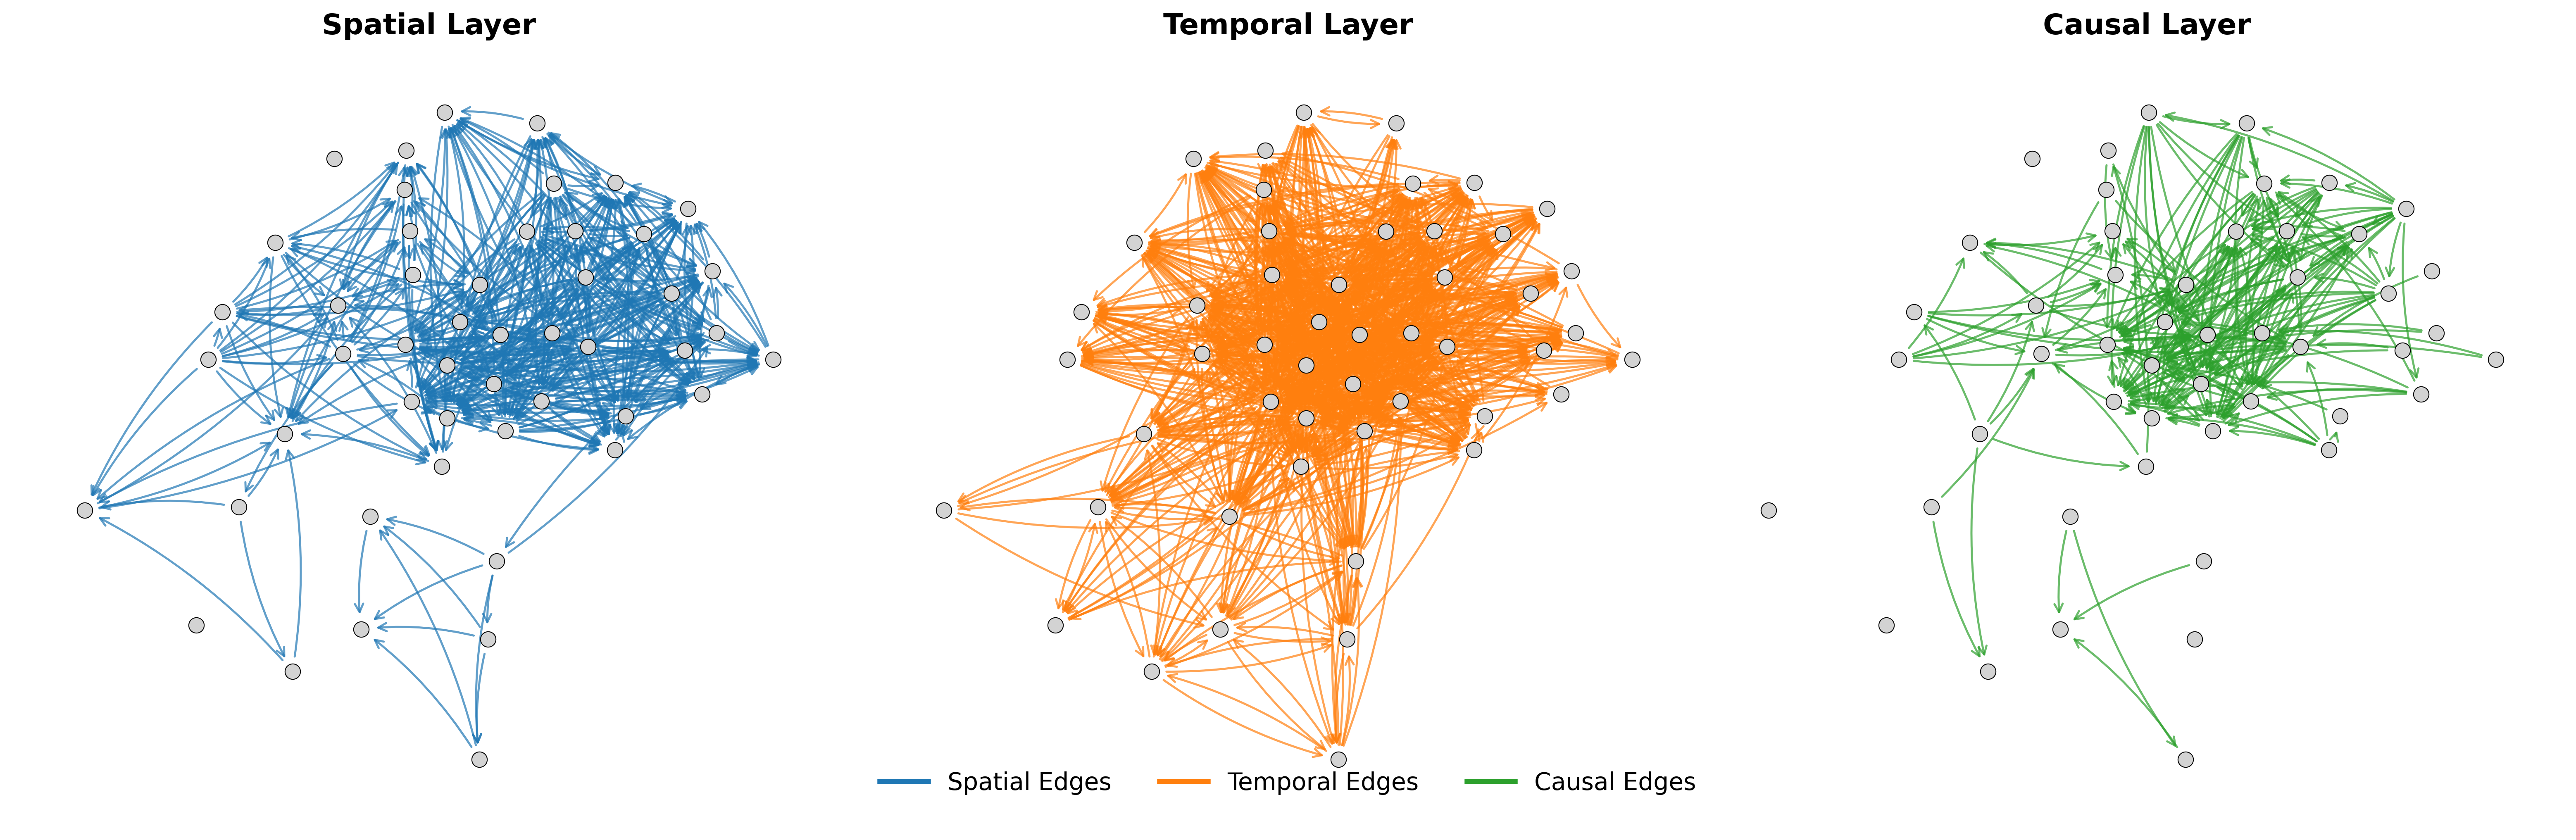

In [13]:
import matplotlib.pyplot as plt
import networkx as nx
import random
import torch

def plot_heterogeneous_graph(data, subset_size=50, layout_seed=42):
    """Plots heterogeneous graph layers with a subset for clarity."""
    plt.rcParams.update({'font.size': 14})  # For research paper readability
    
    # Get all node indices and select subset
    node_indices = list(range(data['substation'].num_nodes))
    if len(node_indices) > subset_size:
        subset_indices = random.sample(node_indices, subset_size)
    else:
        subset_indices = node_indices

    # Create combined graph for consistent layout
    combined_G = nx.Graph()
    combined_G.add_nodes_from(subset_indices)
    edge_types = ['spatial', 'temporal', 'causal']
    colors = {'spatial': '#1f77b4', 'temporal': '#ff7f0e', 'causal': '#2ca02c'}  # Colorblind-friendly
    
    # Add all edges from all types for layout computation
    for edge_type in edge_types:
        edge_index = data['substation', edge_type, 'substation'].edge_index.numpy()
        for i in range(edge_index.shape[1]):
            src, dst = edge_index[0, i], edge_index[1, i]
            if src in subset_indices and dst in subset_indices:
                combined_G.add_edge(src, dst)

    # Compute layout once for consistency
    pos = nx.spring_layout(combined_G, k=0.5, iterations=50, seed=layout_seed)

    # Create figure with subplots
    fig, axes = plt.subplots(1, 3, figsize=(21, 7), dpi=300)
    plt.subplots_adjust(wspace=0.01)  # Reduce space between subplots
    
    # Plot each edge type in separate subplot
    for idx, edge_type in enumerate(edge_types):
        ax = axes[idx]
        G = nx.DiGraph()
        G.add_nodes_from(subset_indices)
        
        # Add edges of this type
        edge_index = data['substation', edge_type, 'substation'].edge_index.numpy()
        edge_count = 0
        for i in range(edge_index.shape[1]):
            src, dst = edge_index[0, i], edge_index[1, i]
            if src in subset_indices and dst in subset_indices:
                G.add_edge(src, dst)
                edge_count += 1
        
        # Skip plotting if no edges in subset
        if edge_count == 0:
            ax.axis('off')
            continue
        
        # Draw nodes and edges
        nx.draw_networkx_nodes(G, pos, ax=ax, node_color='lightgrey', 
                              node_size=80, linewidths=0.5, edgecolors='black')
        nx.draw_networkx_edges(G, pos, ax=ax, edge_color=colors[edge_type],
                              width=1.2, alpha=0.7, arrows=True, 
                              arrowstyle='->', arrowsize=12, 
                              connectionstyle='arc3,rad=0.1')  # Curved edges
        
        # Add layer label
        ax.set_title(f'{edge_type.capitalize()} Layer', fontweight='bold')
        ax.axis('off')

    # Add common legend
    legend_patches = [plt.Line2D([0], [0], color=color, lw=3, 
                      label=f'{et.capitalize()} Edges') 
                     for et, color in colors.items()]
    fig.legend(handles=legend_patches, loc='upper center', 
               ncol=3, bbox_to_anchor=(0.5, 0.12), frameon=False)
    
    plt.tight_layout()
    plt.savefig('heterogeneous_layers.pdf', bbox_inches='tight')  # Vector format for papers
    plt.show()

# Example usage
hetero_graph = torch.load("Hetero_Final_NW_graph_fixed_kara.pt")
plot_heterogeneous_graph(hetero_graph, subset_size=50)

In [14]:
print(node_features_clean.columns.tolist())


['Job Substation', 'X', 'Y', 'Voltage', 'Distribution, Substation, Transmission', 'Substation ID', 'PLANTSTATU', 'no_feeders', 'no_cities', 'total_line_length', 'avg_line_voltage', 'num_connections', 'prior_avg_cust_affected', 'prior_avg_downtime', 'prior_incident_count', 'prior_avg_no_calls', 'Call Qty', 'Job Duration Mins', 'Custs Affected', 'Year', 'Major Storm Event  Y (Yes) or N (No)']


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyArrow, Polygon, Ellipse

def draw_process(ax, x, y, text, width=2.5, height=0.8):
    ax.add_patch(Rectangle((x-width/2, y-height/2), width, height,
                           edgecolor="black", facecolor="white", lw=1.2))
    ax.text(x, y, text, ha="center", va="center", fontsize=9)
    return y-height/2

def draw_startend(ax, x, y, text, width=2.5, height=0.8):
    ax.add_patch(Ellipse((x, y), width, height,
                         edgecolor="black", facecolor="lightgray", lw=1.2))
    ax.text(x, y, text, ha="center", va="center", fontsize=9, fontweight="bold")
    return y-height/2

def draw_decision(ax, x, y, text, width=2.5, height=1.5):
    ax.add_patch(Polygon([[x, y+height/2], [x+width/2, y], [x, y-height/2], [x-width/2, y]],
                         closed=True, edgecolor="black", facecolor="white", lw=1.2))
    ax.text(x, y, text, ha="center", va="center", fontsize=9)
    return y-height/2

def draw_arrow(ax, x1, y1, x2, y2, text=None):
    ax.add_patch(FancyArrow(x1, y1, x2-x1, y2-y1,
                            width=0.01, head_width=0.2, head_length=0.25,
                            length_includes_head=True, color="black"))
    if text:
        ax.text((x1+x2)/2, (y1+y2)/2, text, fontsize=8,
                ha="center", va="center", bbox=dict(facecolor="white", edgecolor="none", pad=0.5))

fig, ax = plt.subplots(figsize=(7,10))
ax.set_xlim(-5,6)
ax.set_ylim(-11,2)
ax.axis("off")

# Start
y = 1.5
draw_startend(ax, 0, y, "Start")

# Set max
y -= 1.5
draw_process(ax, 0, y, "Set max = arr[0]")

# i=1
y -= 1.5
draw_process(ax, 0, y, "i = 1")

# i < length ?
y -= 2
draw_decision(ax, 0, y, "i < length?")

# Yes path -> arr[i] > max?
y_yes = y - 2.2
draw_decision(ax, 0, y_yes, "arr[i] > max?")

# arr[i] > max? -> Yes -> max=arr[i]
y_yes2 = y_yes - 2
draw_process(ax, -2.5, y_yes2, "max = arr[i]")

# i++ (after both Yes and No)
draw_process(ax, 2.5, y_yes2, "i++")
draw_process(ax, -2.5, y_yes2-2, "i++")

# Connect Start to Set max
draw_arrow(ax, 0, 1.1, 0, 0.8)
draw_arrow(ax, 0, 0.3, 0, -0.2)
draw_arrow(ax, 0, -0.7, 0, -1.3)

# From i < length?
draw_arrow(ax, 0, -2.7, 0, -3.3, "Yes")
draw_arrow(ax, 1.3, -2.0, 3.5, -2.0, "No")

# No path -> Return max -> End
draw_process(ax, 3.5, -3.0, "Return max")
draw_startend(ax, 3.5, -4.5, "End")
draw_arrow(ax, 3.5, -2.5, 3.5, -2.7)
draw_arrow(ax, 3.5, -3.5, 3.5, -4.1)

# From arr[i] > max?
draw_arrow(ax, -1.3, -3.8, -2.2, -4.3, "Yes")
draw_arrow(ax, 1.3, -3.8, 2.2, -4.3, "No")

# Yes -> max=arr[i] -> i++ -> back
draw_arrow(ax, -2.5, -4.9, -2.5, -5.3)
draw_arrow(ax, -2.5, -6.0, 0, -6.0)
draw_arrow(ax, 0, -6.0, 0, -5.3)

# No -> i++ -> back
draw_arrow(ax, 2.5, -4.9, 2.5, -5.5)
draw_arrow(ax, 2.5, -5.5, 0, -5.5)
draw_arrow(ax, 0, -5.5, 0, -5.3)

plt.show()
